<a href="https://colab.research.google.com/github/2003UJAN/Crude-Oil-Price-Forecasting/blob/main/Crude_Oil_Price_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow torch statsmodels yfinance plotly streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = yf.download("CL=F", start="2000-01-01", end="2025-01-01")
df = df[['Close']].dropna()
df.rename(columns={'Close': 'Price'}, inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


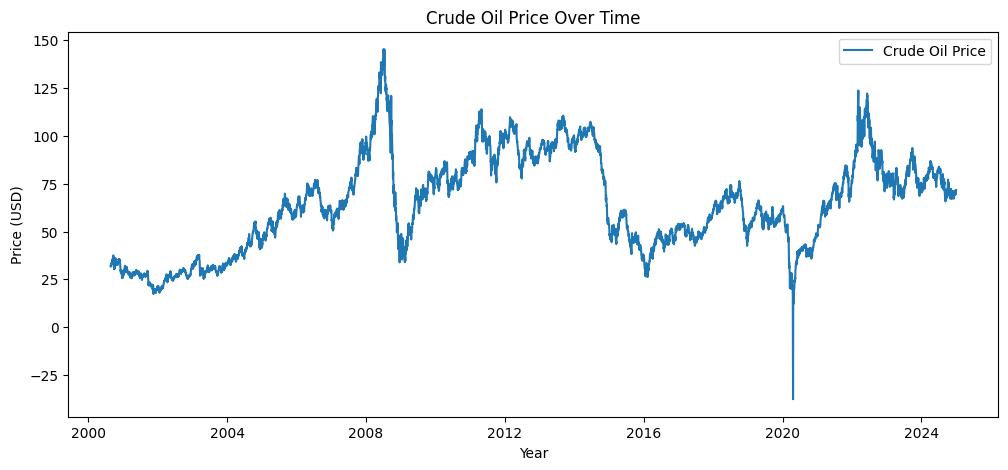

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df, label="Crude Oil Price")
plt.title("Crude Oil Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [5]:
model_arima = ARIMA(df, order=(5,1,0))  # (p,d,q) values tuned manually
model_fit = model_arima.fit()
df['ARIMA_Prediction'] = model_fit.predict()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


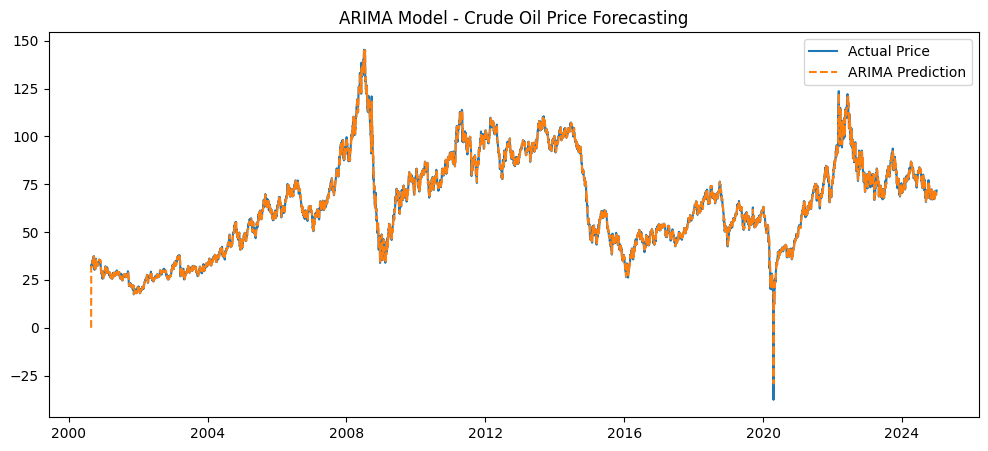

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df['Price'], label="Actual Price")
plt.plot(df['ARIMA_Prediction'], label="ARIMA Prediction", linestyle="dashed")
plt.legend()
plt.title("ARIMA Model - Crude Oil Price Forecasting")
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Price']])

In [8]:
X, y = [], []
time_steps = 60  # Use past 60 days to predict next price
for i in range(time_steps, len(df_scaled)):
    X.append(df_scaled[i-time_steps:i, 0])
    y.append(df_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]


In [10]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.0488 - val_loss: 0.0012
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0029 - val_loss: 6.1803e-04
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 0.0025 - val_loss: 9.4700e-04
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0023 - val_loss: 6.0889e-04
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0022 - val_loss: 5.8964e-04
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0020 - val_loss: 6.4563e-04
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0020 - val_loss: 4.9132e-04
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0017 - val_loss: 5.3223e-04
Epoch 10/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0015 - val_loss: 7.0200e-04
Epoch 11/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0015 - val_loss: 6.0319e

In [12]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


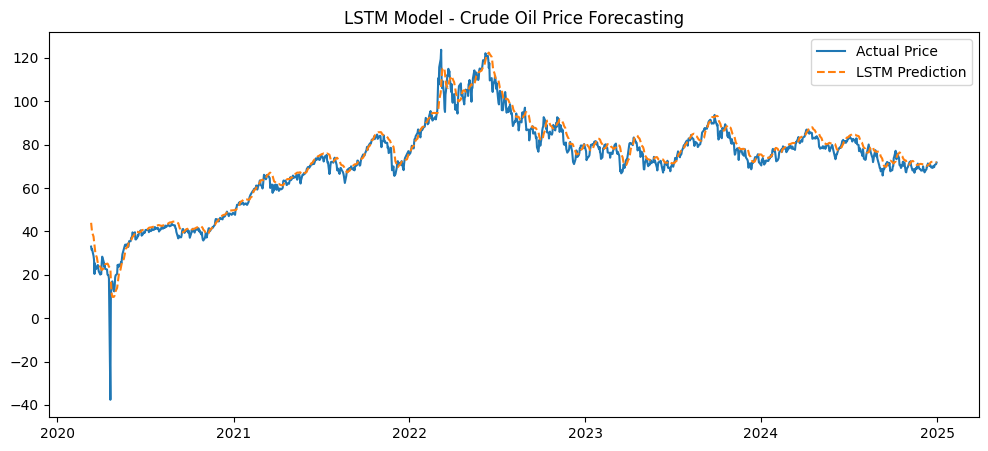

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df.index[train_size+time_steps:], df['Price'][train_size+time_steps:], label="Actual Price")
plt.plot(df.index[train_size+time_steps:], y_pred_lstm, label="LSTM Prediction", linestyle="dashed")
plt.legend()
plt.title("LSTM Model - Crude Oil Price Forecasting")
plt.show()

In [15]:
model_lstm.save("lstm_model.h5")